In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
batch_size = 32
img_width = 299
img_height=299
data_dir='/storage/data/wildflower'

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1052 files belonging to 3 classes.
Using 842 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1052 files belonging to 3 classes.
Using 210 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)


['Arabis procurrens', 'Erodium cicutarium', 'Pulsatilla alpina alba']


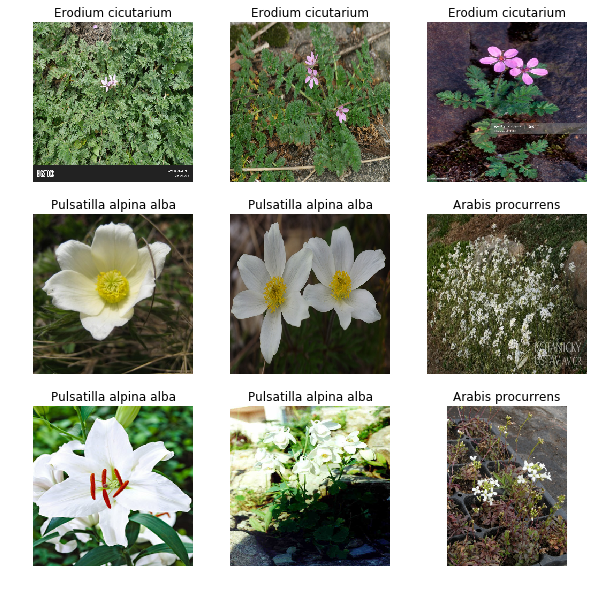

In [31]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


#### Optimize performance

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Simple ConvNet without augmentation, dropout, etc

In [19]:
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



In [20]:
model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 299, 299, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 149, 149, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 64)       

In [22]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
27/27 [==============================] - 98s 4s/step - loss: 1.3605 - accuracy: 0.3705 - val_accuracy: 0.3905 - val_loss: 1.0735
Epoch 2/10
27/27 [==============================] - 95s 4s/step - loss: 1.0191 - accuracy: 0.4857 - val_accuracy: 0.5286 - val_loss: 0.9896
Epoch 3/10
27/27 [==============================] - 93s 3s/step - loss: 0.7618 - accuracy: 0.6983 - val_accuracy: 0.5381 - val_loss: 1.0372
Epoch 4/10
27/27 [==============================] - 93s 3s/step - loss: 0.6242 - accuracy: 0.7767 - val_accuracy: 0.5952 - val_loss: 0.9379
Epoch 5/10
27/27 [==============================] - 95s 4s/step - loss: 0.4139 - accuracy: 0.8504 - val_accuracy: 0.6952 - val_loss: 0.7294
Epoch 6/10
27/27 [==============================] - 93s 3s/step - loss: 0.2123 - accuracy: 0.9240 - val_accuracy: 0.6429 - val_loss: 1.0182
Epoch 7/10
27/27 [==============================] - 93s 3s/step - loss: 0.1089 - accuracy: 0.9691 - val_accuracy: 0.6857 - val_loss: 0.8570
Epoch 8/10
27/27 [==

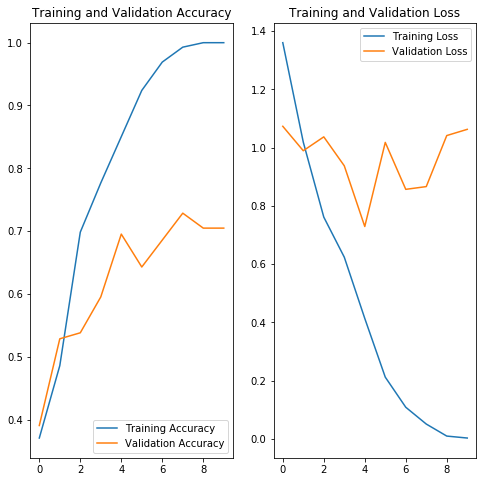

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see in the images above, our models suffersfrom overfitting the training data.

### Data Augmentation

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


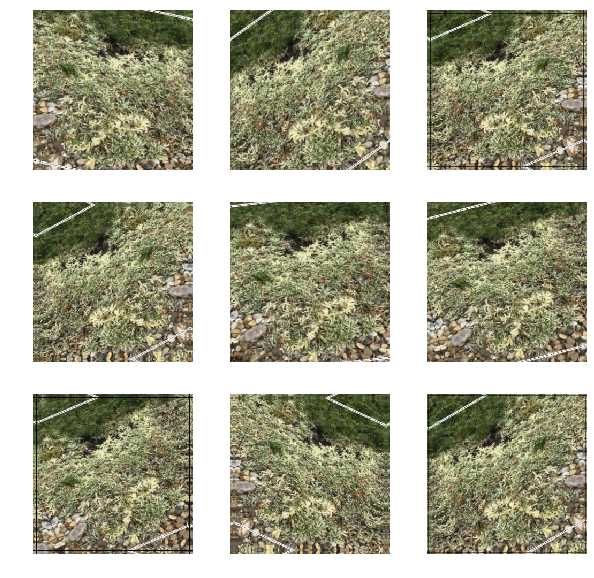

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### New Model with Augmentation and dropout

In [35]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [37]:
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 299, 299, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 149, 149, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 74, 74, 64)       

In [38]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
27/27 [==============================] - 111s 4s/step - loss: 1.6883 - accuracy: 0.3551 - val_accuracy: 0.3619 - val_loss: 1.0856
Epoch 2/15
27/27 [==============================] - 110s 4s/step - loss: 1.0422 - accuracy: 0.4501 - val_accuracy: 0.4524 - val_loss: 1.0658
Epoch 3/15
27/27 [==============================] - 109s 4s/step - loss: 1.0725 - accuracy: 0.4525 - val_accuracy: 0.3476 - val_loss: 1.0692
Epoch 4/15
27/27 [==============================] - 108s 4s/step - loss: 1.0462 - accuracy: 0.4228 - val_accuracy: 0.4714 - val_loss: 1.0193
Epoch 5/15
27/27 [==============================] - 109s 4s/step - loss: 0.9678 - accuracy: 0.5226 - val_accuracy: 0.4619 - val_loss: 1.0090
Epoch 6/15
27/27 [==============================] - 111s 4s/step - loss: 0.8844 - accuracy: 0.5796 - val_accuracy: 0.4857 - val_loss: 1.0759
Epoch 7/15
27/27 [==============================] - 110s 4s/step - loss: 0.8107 - accuracy: 0.6378 - val_accuracy: 0.4952 - val_loss: 1.1120
Epoch 8/15
27

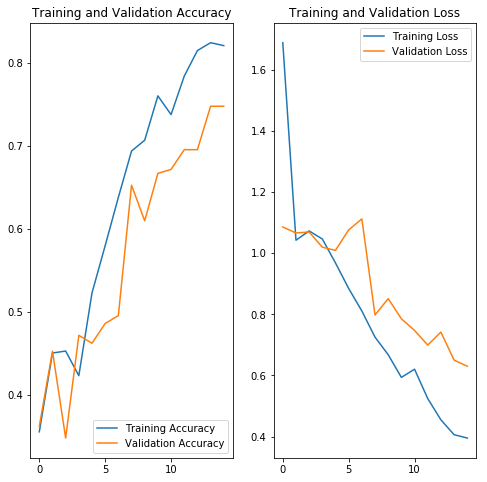

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


With dropout and image augmentation we improved our model quite a bit. in the next step we will make use of transfer learning techniques.

#### Resnet

In [8]:
img_size = (299, 299)
img_shape = img_size + (3,)
base_model = tf.keras.applications.InceptionResNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

In [9]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1536)


In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3)),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
  
    ])

In [11]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [12]:
base_model.trainable = False

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1536)


In [14]:
prediction_layer = tf.keras.Sequential([tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(18, kernel_regularizer='l1', activation='softmax')
                                       ])
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 18)


In [15]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 18)               

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])


In [18]:
initial_epochs = 15
loss0, accuracy0 = model.evaluate(val_ds)


7/7 [==============================] - 94s 13s/step - accuracy: 0.0238 - loss: 6.4089


In [19]:
history_res = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/15
27/27 [==============================] - 560s 21s/step - accuracy: 0.4466 - loss: 5.0125 - val_loss: 4.4760 - val_accuracy: 0.5714
Epoch 2/15
27/27 [==============================] - 560s 21s/step - accuracy: 0.6223 - loss: 4.2292 - val_loss: 4.2022 - val_accuracy: 0.6000
Epoch 3/15
27/27 [==============================] - 562s 21s/step - accuracy: 0.6829 - loss: 3.9890 - val_loss: 4.1095 - val_accuracy: 0.6048
Epoch 4/15
27/27 [==============================] - 571s 21s/step - accuracy: 0.7660 - loss: 3.7426 - val_loss: 3.9974 - val_accuracy: 0.6333
Epoch 5/15
27/27 [==============================] - 560s 21s/step - accuracy: 0.7732 - loss: 3.5976 - val_loss: 3.7290 - val_accuracy: 0.7000
Epoch 6/15
27/27 [==============================] - 561s 21s/step - accuracy: 0.7957 - loss: 3.4635 - val_loss: 3.7878 - val_accuracy: 0.6333
Epoch 7/15
27/27 [==============================] - 564s 21s/step - accuracy: 0.8171 - loss: 3.3024 - val_loss: 3.5261 - val_accuracy: 0.7048
Epoch 

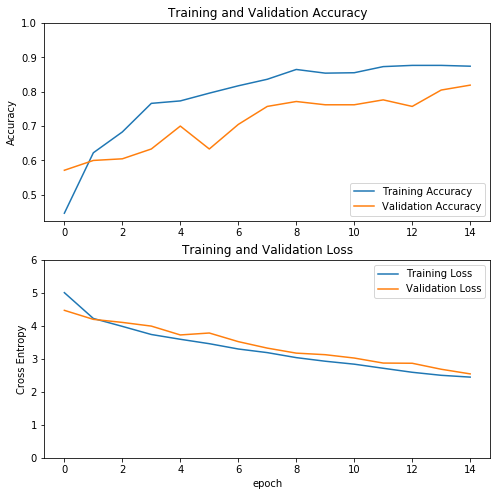

In [20]:
acc = history_res.history['accuracy']
val_acc = history_res.history['val_accuracy']

loss = history_res.history['loss']
val_loss = history_res.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,6.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
model.save('storage/inception_resnet')


In [22]:
#keras.models.load_model("my_model")


In [23]:
base_model.trainable = True

In [24]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 500


for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


In [25]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])


In [26]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_res_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history_res.epoch[-1],
                         validation_data=val_ds)


Epoch 15/30
27/27 [==============================] - 898s 33s/step - accuracy: 0.9109 - loss: 2.2987 - val_loss: 2.3453 - val_accuracy: 0.8857
Epoch 16/30
27/27 [==============================] - 892s 33s/step - accuracy: 0.9382 - loss: 2.2007 - val_loss: 2.3230 - val_accuracy: 0.9048
Epoch 17/30
27/27 [==============================] - 889s 33s/step - accuracy: 0.9466 - loss: 2.1649 - val_loss: 2.3087 - val_accuracy: 0.9048
Epoch 18/30
27/27 [==============================] - 891s 33s/step - accuracy: 0.9430 - loss: 2.1538 - val_loss: 2.2155 - val_accuracy: 0.9381
Epoch 19/30
27/27 [==============================] - 888s 33s/step - accuracy: 0.9632 - loss: 2.1092 - val_loss: 2.2184 - val_accuracy: 0.9524
Epoch 20/30
27/27 [==============================] - 893s 33s/step - accuracy: 0.9656 - loss: 2.0944 - val_loss: 2.1964 - val_accuracy: 0.9476
Epoch 21/30
27/27 [==============================] - 895s 33s/step - accuracy: 0.9810 - loss: 2.0497 - val_loss: 2.1805 - val_accuracy: 0.9381

In [27]:
acc += history_res_fine.history['accuracy']
val_acc += history_res_fine.history['val_accuracy']

loss += history_res_fine.history['loss']
val_loss += history_res_fine.history['val_loss']

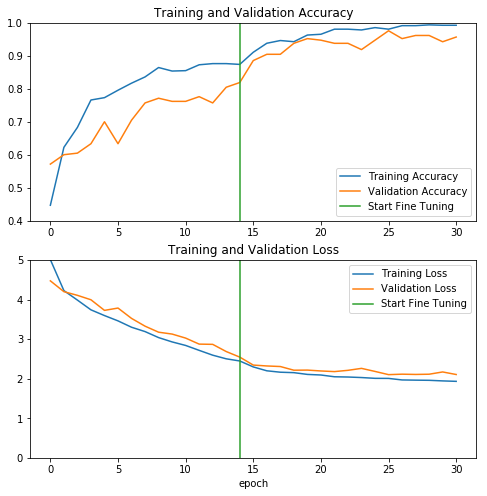

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()